In [1]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import uproot#4 as uproot
import awkward as ak
from skspatial.plotting import plot_3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import random
import math
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import os
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.special import loggamma
from gaussian2d import gaussian2d, make_nll
from iminuit import Minuit


In [2]:
difMomTheta = np.load('shion_data/shion_contour.npy')[0]
difMomPhi = np.load('shion_data/shion_contour.npy')[1]

minuit.values:
<ValueView mu_x=-0.015117904509422492 mu_y=0.006325208809329122 sigma_x=0.9690488789785364 sigma_y=2.736536995081691 a=18222.04230720818 corr=0.0008375932799563661>
minuit.errors:
<ErrorView mu_x=0.0003274049307753705 mu_y=0.0009814452299337331 sigma_x=0.00024499708351832794 sigma_y=0.0008569273719620796 a=6.123822765302975 corr=0.0003662020709559559>
minuit.params:
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu_x    │ -15.12e-3 │  0.33e-3  │  -0.33e-3  │  0.33e-3   │         │         │       │
│ 1 │ mu_y    │  6.3e-3   │  1.0e-3   │  -1.0e-3   │   1.0e-3   │         │         │       │
│ 2 │ sigma_x │ 969.05e-3 │  0.24e-3  │  -0.24e-3  │  0.25e-3   │    0    │         │       │
│ 3 │ sigma_y │  2.7365   │  0.0009   │  -0.0009   │

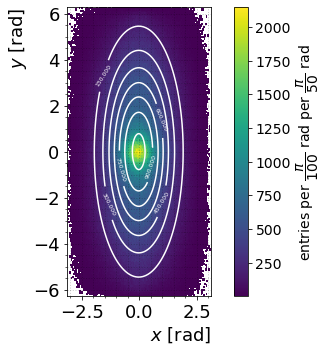

In [3]:
# binning for 2d histogram
x_bin_lower, x_bin_upper, x_bin_width = -np.pi, np.pi, 2*np.pi/200
y_bin_lower, y_bin_upper, y_bin_width = -2*np.pi, 2*np.pi, 4*np.pi/200
  
# bins for the 2D histogram
x_bins = np.arange(x_bin_lower, x_bin_upper+x_bin_width, x_bin_width)
y_bins = np.arange(y_bin_lower, y_bin_upper+y_bin_width, y_bin_width)
    
# plot aesthetics
ax_font_size = 18
z_font_size = 14

# plot labels
x_unit = 'rad'
y_unit = 'rad'
x_label = '$x$ [{}]'.format(x_unit)
y_label = '$y$ [{}]'.format(y_unit)
z_label = 'entries per $\dfrac{\u03C0}{100}$ rad per $\dfrac{\u03C0}{50}$ rad'

counts, x_edges, y_edges = np.histogram2d(difMomTheta, difMomPhi, bins=(x_bins, y_bins))
minuit = Minuit(
        fcn=make_nll(x_edges, y_edges, counts),
        mu_x=0,
        mu_y=0,
        sigma_x=1,
        sigma_y=1,
        a=10000,
        corr=0,
        )
# set step sizes for minuit's numerical gradient estimation
minuit.errors = (1e-5, 1e-5, 1e-5, 1e-5, 1e-1, 1e-5)

# set limits for each parameter
minuit.limits = [None, None, (0, None), (0, None), (0, None), (-1, 1)]

# set errordef for a negative log-likelihood (NLL) function
minuit.errordef = Minuit.LIKELIHOOD
# minuit.errordef = Minuit.LEAST_SQUARES  # for a least-squares cost function

# run migrad minimizer
minuit.migrad(ncall=1000000)

# print estimated parameters
print('minuit.values:')
print(minuit.values)
    
# run hesse algorithm to compute asymptotic errors
minuit.hesse()

# print estimated errors on estimated parameters
print('minuit.errors:')
print(minuit.errors)

# run minos algorithm to compute confidence intervals
minuit.minos()

# print estimated parameters
print('minuit.params:')
print(minuit.params)

# print estimated errors on estimated parameters
print('minuit.merrors:')
print(minuit.merrors)


#--------------------------------------------------------------------------
# chi2
#--------------------------------------------------------------------------
    
x_bin_centers = 0.5*(x_edges[1:]+x_edges[:-1])
y_bin_centers = 0.5*(y_edges[1:]+y_edges[:-1])
x_, y_ = np.meshgrid(x_bin_centers, y_bin_centers)
z_ = gaussian2d(
    x_, y_,
    minuit.values['mu_x'],
    minuit.values['mu_y'],
    minuit.values['sigma_x'],
    minuit.values['sigma_y'],
    minuit.values['a'],
    minuit.values['corr']
    )

mask = counts == 0
z_fit = z_[~mask]

chi2 = ((z_fit - counts[~mask])**2 / z_fit).sum()
dof = len(z_fit) - len(minuit.values)

# reduced chi2
print('chi2 / dof = {} / {} = {}'.format(chi2, dof, chi2/dof))

#//////////////////////////////////////////////////////////////////////////
# plot histogram of the sample and estimated bivariate Gaussian function
#//////////////////////////////////////////////////////////////////////////

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

#--------------------------------------------------------------------------
# plot the 2D histogram
#--------------------------------------------------------------------------
x, y = np.meshgrid(x_bins, y_bins)
p = ax.pcolormesh(x, y, np.ma.masked_where(counts == 0, counts).T,
                    shading='auto')  # with mask
# p = ax.pcolormesh(x, y, counts.T, shading='auto')  # without mask
p.set_rasterized(True)
#--------------------------------------------------------------------------
# create color bar for the 2D histogram
#--------------------------------------------------------------------------
cb = fig.colorbar(p)
cb.ax.tick_params(labelsize=z_font_size)
cb.ax.yaxis.offsetText.set_fontsize(z_font_size)
cb.ax.yaxis.set_offset_position('left')
cb.set_label(z_label, rotation=90, fontsize=z_font_size)  # z label

#--------------------------------------------------------------------------
# use the estimated parameters plot the bivariate Gaussian function
#--------------------------------------------------------------------------
z = gaussian2d(
    x, y,
    minuit.values['mu_x'],
    minuit.values['mu_y'],
    minuit.values['sigma_x'],
    minuit.values['sigma_y'],
    minuit.values['a'],
    minuit.values['corr']
    )

# plot contour of the bivariate Gaussian function
c = ax.contour(x, y, z, levels=7, colors='w', linewidths=1.5, alpha=1)
ax.clabel(c, inline=True, fontsize=6)

#--------------------------------------------------------------------------
# set plot aesthetics
#--------------------------------------------------------------------------
# set aspect ratio to 1:1
ax.set_aspect('equal')

# set labels
ax.set_xlabel(x_label, horizontalalignment='right', x=1.0,
                fontsize=ax_font_size)
ax.set_ylabel(y_label, horizontalalignment='right', y=1.0,
                    fontsize=ax_font_size)

# configure tick properties
ax.tick_params(axis='both', which='major', labelsize=ax_font_size)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# set grid lines
ax.grid(True, which='both', axis='both', color='k', linestyle=':',
        linewidth=1, alpha=0.2)

#--------------------------------------------------------------------------
# plot
#--------------------------------------------------------------------------
plt.tight_layout()
plt.show()
